# Data preparation

In [1]:
%load_ext autoreload
%autoreload 2
import json
from src.ingestion.download_related_paper_datasets import download_related_paper_datasets
from src.ingestion.download_samples import download_samples
import seaborn as sns
from wordcloud import WordCloud
from io import StringIO
import matplotlib.pyplot as plt
from src.analysis.analyzer import DatasetAnalyzer
from src.visualization.visualize_clusters import visualize_clusters_jupyter
from src.visualization.get_topic_table import get_topic_table
import aiohttp
import asyncio
import pandas as pd
import itertools
import spacy
import scispacy
from scispacy.linking import EntityLinker
from src.model.geo_dataset import GEODataset
from src.model.geo_sample import GEOSample
from typing import Tuple, List, Dict, Set
from dateutil.parser import parse as parse_date
import datetime
from src.parsing.age.get_age import get_sample_ages
from src.tissue_and_cell_type_standardization.standardization_resources import StandardizationResources

{"asctime": "2025-06-16 10:44:50,850", "levelname": "INFO", "message": "Registering at the factory, space: dummy distance type: INT"}
{"asctime": "2025-06-16 10:44:50,851", "levelname": "INFO", "message": "Registering at the factory, space: dummy distance type: FLOAT"}
{"asctime": "2025-06-16 10:44:50,851", "levelname": "INFO", "message": "Registering at the factory, space: bit_hamming distance type: INT"}
{"asctime": "2025-06-16 10:44:50,851", "levelname": "INFO", "message": "Registering at the factory, space: bit_jaccard distance type: FLOAT"}
{"asctime": "2025-06-16 10:44:50,852", "levelname": "INFO", "message": "Registering at the factory, space: leven distance type: INT"}
{"asctime": "2025-06-16 10:44:50,852", "levelname": "INFO", "message": "Registering at the factory, space: normleven distance type: FLOAT"}
{"asctime": "2025-06-16 10:44:50,853", "levelname": "INFO", "message": "Registering at the factory, space: kldivfast distance type: FLOAT"}
{"asctime": "2025-06-16 10:44:50,8

In [2]:
paper_export = json.load(open("GEO_Datasets/pubmed-hallmarks-of-aging-an-expanding-universe.json"))
datasets = download_related_paper_datasets(paper_export)
print(len(datasets))

/home/Momir.Milutinovic/repos/pubmed-paper-exploration/src/ingestion/download_related_paper_datasets.py:15: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_json(paper_export["df"])


371


# Dataset metadata

## Experiment types

In [3]:
experiment_types = [dataset.experiment_type for dataset in datasets]
print(experiment_types[0:10])

['Expression profiling by high throughput sequencing', 'Expression profiling by array', 'Expression profiling by high throughput sequencing', 'Methylation profiling by high throughput sequencing', 'Methylation profiling by genome tiling array', 'Expression profiling by high throughput sequencing', 'Methylation profiling by genome tiling array', 'Expression profiling by high throughput sequencing', 'Expression profiling by high throughput sequencing', 'Expression profiling by array']


/home/Momir.Milutinovic/repos/pubmed-paper-exploration/.venv/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)


Text(0.5, 9.444444444444438, 'Count')

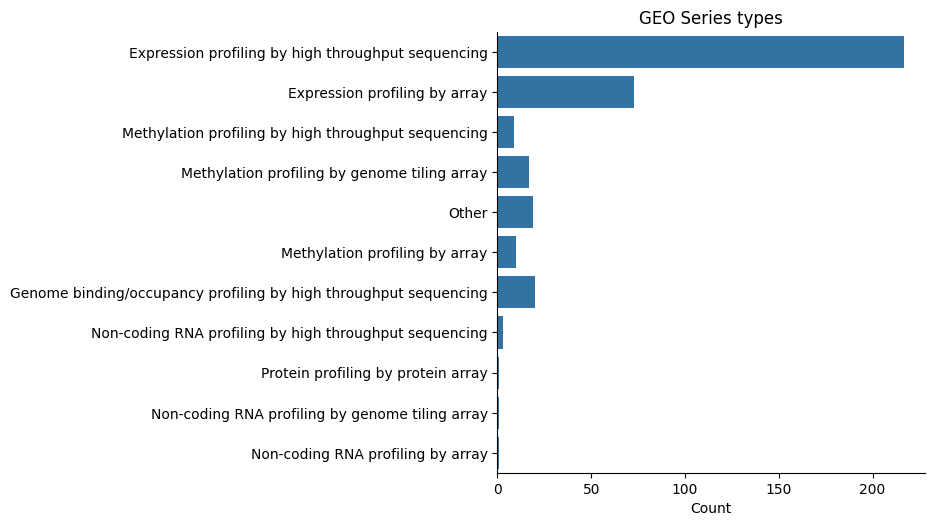

In [4]:
sns.catplot(experiment_types, kind="count")
plt.title("GEO Series types")
plt.xlabel("Count")

Most experiments are done through expression profiling by high throughput sequencing.

## Organisms

In [5]:
def replace_low_frequency_levels_with_other(pd_series, threshold):
    value_counts = pd_series.value_counts()
    low_freq_categories = value_counts[value_counts < threshold].index

    # Replace low-frequency categories with "Other"
    return pd_series.where(~pd_series.isin(low_freq_categories), 'Other')

49
Homo sapiens              198
Mus musculus              147
Other                      72
Rattus norvegicus          12
Caenorhabditis elegans     11
Name: count, dtype: int64
0.39622641509433965
371


Text(0.5, 9.444444444444438, '# Series')

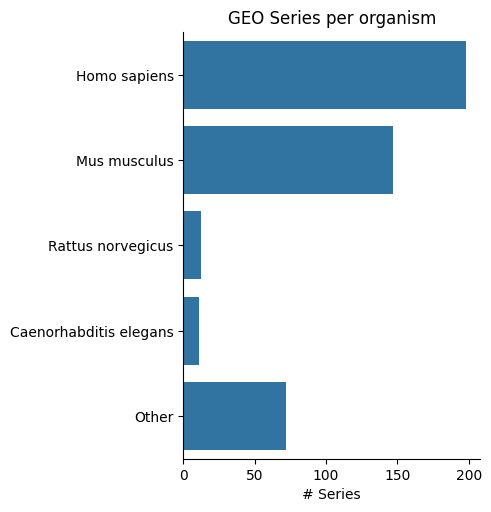

In [6]:
organisms = [organism for dataset in datasets for organism in dataset.organisms]
print(len(set(organisms)))
organisms = pd.Series(organisms)
organisms = replace_low_frequency_levels_with_other(organisms, 10)
print(organisms.value_counts())
print((147)/371)
print(len(datasets))
sns.catplot(organisms, kind="count", order=["Homo sapiens", "Mus musculus", "Rattus norvegicus", "Caenorhabditis elegans", "Other"])
plt.title("GEO Series per organism")
plt.xlabel("# Series")

Most datasets are collected from either mice or people.

In [7]:
## Title wordcolud

In [8]:
from typing import List
def plot_wordcloud(strings: List[str]):
    """
    Plots a wordcloud of a list of strings.
    """
    si = StringIO()
    for string in strings:
        si.write(string)
    text = si.getvalue()
    wordcloud = WordCloud().generate(text)
    wordcloud = WordCloud(background_color="white",max_words=len(text),max_font_size=40,).generate(text)
    plt.figure()
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

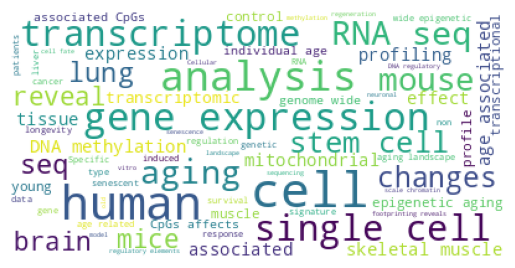

In [9]:
plot_wordcloud([dataset.title for dataset in datasets])

## Summary wordcolud

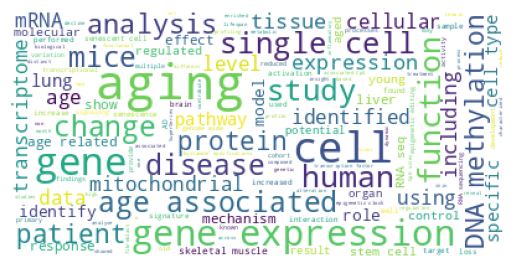

In [10]:
plot_wordcloud([dataset.summary for dataset in datasets])


## Overall design wordcolud

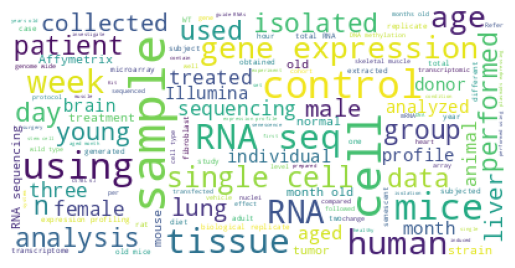

In [11]:
plot_wordcloud([dataset.overall_design for dataset in datasets])

## Platform ID counts

<Figure size 1000x2000 with 0 Axes>

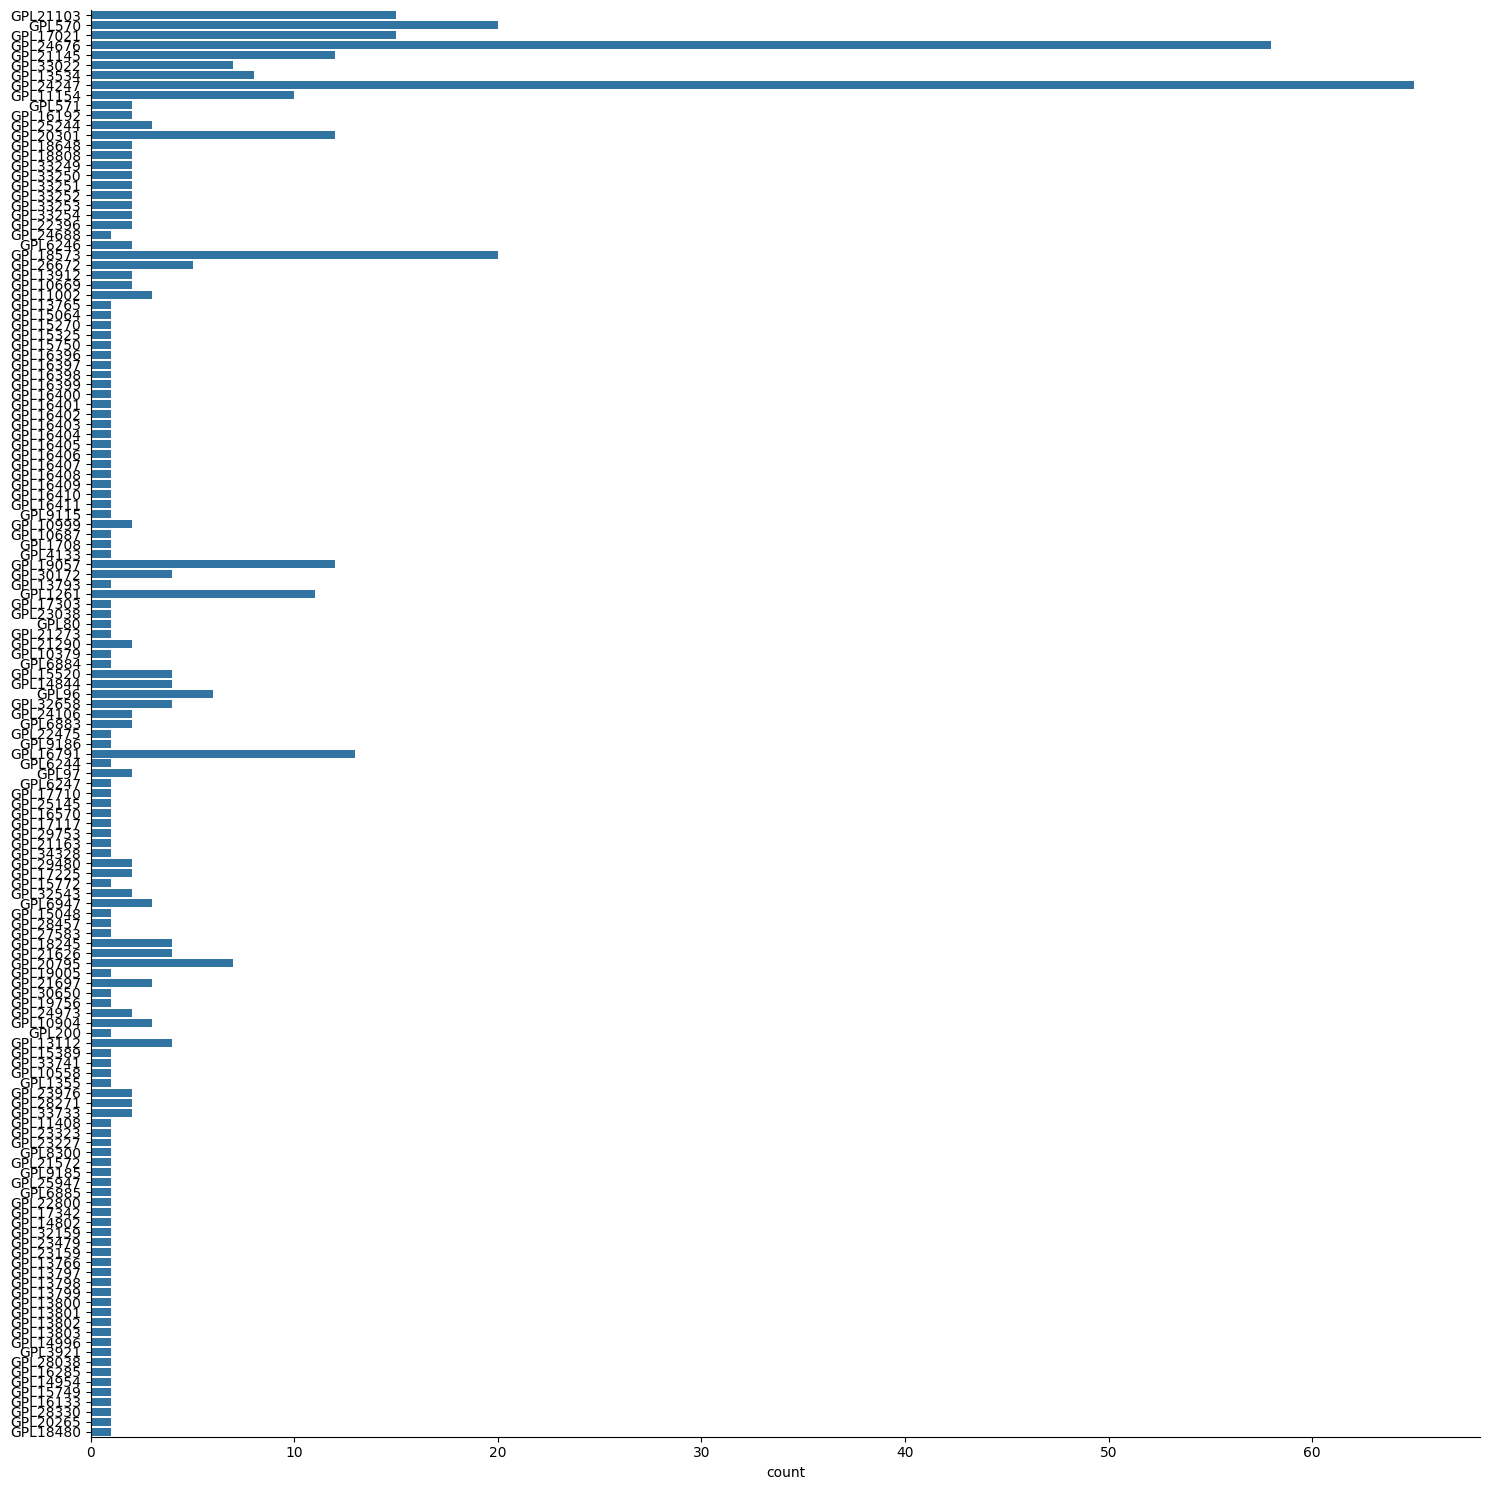

In [12]:
platform_ids = [platform_id for dataset in datasets for platform_id in dataset.platform_ids]
plt.figure(figsize=(10, 20))
sns.catplot(platform_ids, kind="count", height=15)
plt.show()

The top two platform IDs correspond to the Illumina Nova Seq 6000 sequencer. There is one platform record for when it is used and people and another one for mice. This is not surprising as Illumina sequencers are widely used in genomics research.

## Publication date

{"asctime": "2025-06-16 10:44:58,805", "levelname": "INFO", "message": "Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting."}
{"asctime": "2025-06-16 10:44:58,813", "levelname": "INFO", "message": "Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting."}


<Axes: title={'center': 'Datasets per year'}, xlabel='Year', ylabel='Number of datasets'>

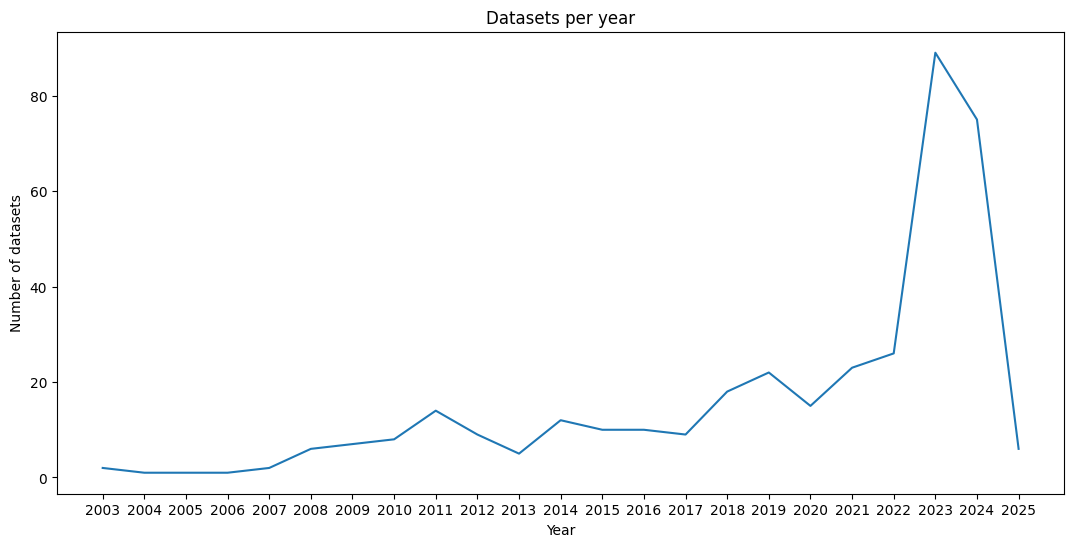

In [13]:
years = [str(dataset.publication_date.year) for dataset in datasets]
years = pd.DataFrame(years, columns=["year"])
years = years.groupby(["year"], as_index=False).agg(count=("year", "count"))
fig, ax = plt.subplots(figsize=(13, 6))
plt.title("Datasets per year")
plt.xlabel("Year")
plt.ylabel("Number of datasets")
sns.lineplot(years, x="year", y="count", ax=ax)

## Country

<Axes: title={'center': 'Number of datasets from each country'}, xlabel='count'>

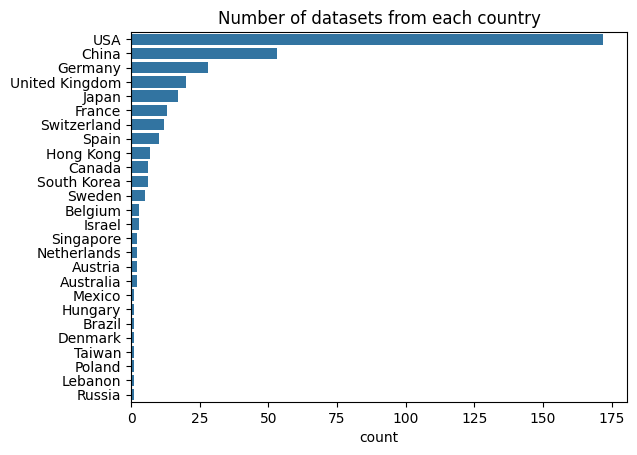

In [14]:
countries = pd.Series([dataset.metadata["contact_country"][0] for dataset in datasets])
plt.title("Number of datasets from each country")
sns.countplot(countries, order=countries.value_counts().index)

# Clustering

In [15]:
svd_dimensions = 15
topic_words = 10
best_result = None
best_score = -1
best_n_clusters = None

for n_clusters in range(5, 20):
    analyzer = DatasetAnalyzer(svd_dimensions, n_clusters)
    result = analyzer.analyze_datasets(datasets)
    if result.silhouette_score > best_score:
        best_score = result.silhouette_score
        best_result = result
        best_n_clusters = n_clusters

print(f"Best number of clusters {best_n_clusters}")

{"asctime": "2025-06-16 10:44:59,293", "levelname": "INFO", "message": "Explained variance of the SVD step: 19.5 %"}
{"asctime": "2025-06-16 10:44:59,317", "levelname": "INFO", "message": "Silhouette score: 0.1752196938318994"}
{"asctime": "2025-06-16 10:44:59,320", "levelname": "INFO", "message": "Clustering time: 0.02s"}
{"asctime": "2025-06-16 10:45:00,149", "levelname": "INFO", "message": "Explained variance of the SVD step: 19.5 %"}
{"asctime": "2025-06-16 10:45:00,171", "levelname": "INFO", "message": "Silhouette score: 0.20515137117901575"}
{"asctime": "2025-06-16 10:45:00,174", "levelname": "INFO", "message": "Clustering time: 0.02s"}
{"asctime": "2025-06-16 10:45:00,997", "levelname": "INFO", "message": "Explained variance of the SVD step: 19.5 %"}
{"asctime": "2025-06-16 10:45:01,017", "levelname": "INFO", "message": "Silhouette score: 0.2210153517389739"}
{"asctime": "2025-06-16 10:45:01,019", "levelname": "INFO", "message": "Clustering time: 0.02s"}
{"asctime": "2025-06-16 

Similar datasets are located close to each other.
The color of a point represnts the topic of the dataset.

In [16]:
visualize_clusters_jupyter(best_result.df, best_result.cluster_topics)

Loading BokehJS ...

## Topics

In [17]:
topic_table = get_topic_table(best_result.cluster_topics, best_result.df)
topic_df = pd.DataFrame(topic_table, columns=["#", "Datasets", "Color", "Topics"])
topic_df = topic_df.set_index("#")
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
# Apply styling to the 'color' column
topic_df = topic_df[["Color", "Datasets", "Topics"]].style.map(lambda x: f"background-color: {x};" if type(x) == str and x.startswith("#") else "")\
    .map(lambda x: f"color: {x};" if type(x) == str and x.startswith("#") else "")
topic_df

,Color,Datasets,Topics
#,,,
1,#1f77b4,66,"mice, aging, musculus, mus, old, mouse, young, liver, months, age"
2,#aec7e8,57,"cell, single, cells, human, stem, seq, tissue, specific, transcriptional, aging"
3,#ff7f0e,39,"brain, transcriptome, aged, analysis, adult, post, disease, bone, mrna, array"
4,#ffbb78,36,"lung, cancer, tumor, patients, gene, samples, molecular, breast, non, array"
5,#2ca02c,35,"mitochondrial, lifespan, protein, elegans, daf, longevity, activity, aal1, translation, revealed"
6,#98df8a,26,"senescent, senescence, cells, sasp, induced, cellular, stress, profile, replicates, known"
7,#d62728,21,"methylation, dna, blood, schizophrenia, controls, genome, study, cases, samples, illumina"
8,#ff9896,20,"muscle, skeletal, subjects, dnmt3a, biopsies, older, regulation, insulin, african, americans"
9,#9467bd,18,"chromatin, ad, accessibility, hippocampus, dependent, binding, cellular, alzheimer, neuronal, sex"


# Sample metadata

In [18]:
# Download samples
samples = set() # We are using a set because some samples can occur twice. For example, a sample appears twice when it is in a subseries and superseries
async with aiohttp.ClientSession() as session:
    for series in datasets:
        try:
            series.samples = await download_samples(series, session)
            samples.update(series.samples)
        except aiohttp.ServerDisconnectedError:
            session = await session.close()
            session = aiohttp.ClientSession()
            series.samples = await download_samples(series, session)
            samples.update(series.samples)

accessions = [sample.accession for sample in samples]
assert len(set(accessions)) == len(samples)

## Number of samples

In [19]:
len(samples)

44591

## Number of samples per dataset

/tmp/ipykernel_969929/3117547129.py:29: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_plot = n_samples_df.groupby(by="cats")["samples"].count()


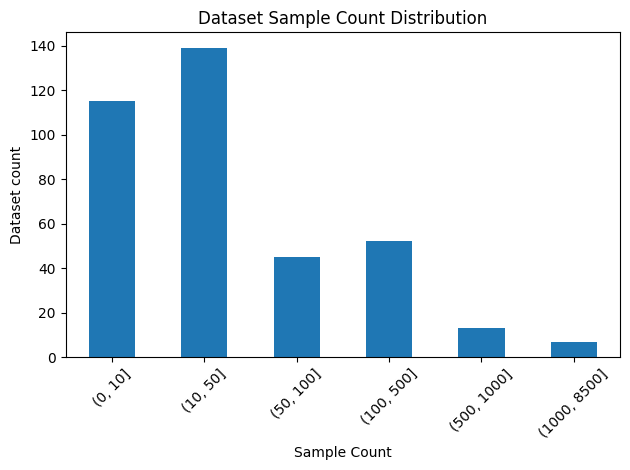

In [20]:
# https://stackoverflow.com/a/71540059
import scipy.stats as stats

number_of_samples_per_dataset = pd.Series(sorted([len(dataset.samples) for dataset in datasets]))
percent_of_samples_per_dataset = number_of_samples_per_dataset / number_of_samples_per_dataset.sum() 
n_samples_df = percent_of_samples_per_dataset.to_frame()
n_samples_df = n_samples_df.rename(columns={0: 'sample_share'})
n_samples_df["samples"] = number_of_samples_per_dataset

n = len(percent_of_samples_per_dataset)
#define bins in percent
#the last valueis slightly above 100% to ensure that the final bin is included
bins = [0, 10, 50, 100, 500, 1000, 8500]

def find_last_index(lst, condition):
    last_index = -1
    for index, value in enumerate(lst):
        if condition(value):
            last_index = index
    return last_index

rank_bins = [0] + [find_last_index(number_of_samples_per_dataset, lambda x: x <= bin) for bin in bins[1:-1]] + [len(number_of_samples_per_dataset)]
#create figure labels for intervals from bins
labels = [f"({start}, {stop}]" for start, stop in zip(bins[:-1], bins[1:])]


n_samples_df["cats"] = pd.cut(n_samples_df.index, bins=rank_bins, include_lowest=True, right=False, labels=labels)
#and aggregate
df_plot = n_samples_df.groupby(by="cats")["samples"].count()

df_plot.plot.bar(rot=45, xlabel="Sample Count", ylabel="Dataset count", title="Dataset Sample Count Distribution")

plt.tight_layout()
plt.show()

## Most common sample types

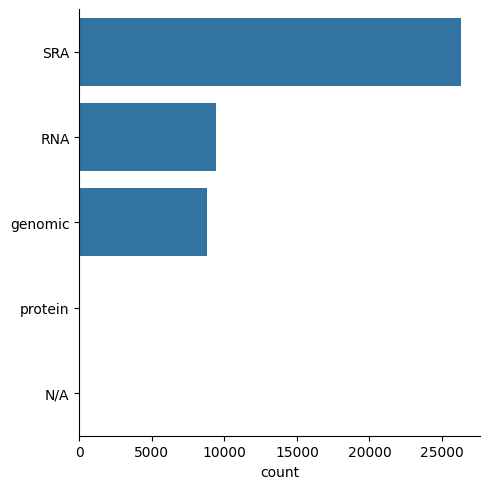

In [21]:
sample_types = [sample.sample_type for sample in samples]
sns.catplot(sample_types, kind="count")

## Most common characteristics keys

In [22]:
def remove_low_frequency_levels(pd_series, threshold):
    value_counts = pd_series.value_counts()
    low_freq_categories = value_counts[value_counts < threshold].index
    return pd_series[~pd_series.isin(low_freq_categories)]

Text(0.5, 1.0, 'Most common characterisitics keys')

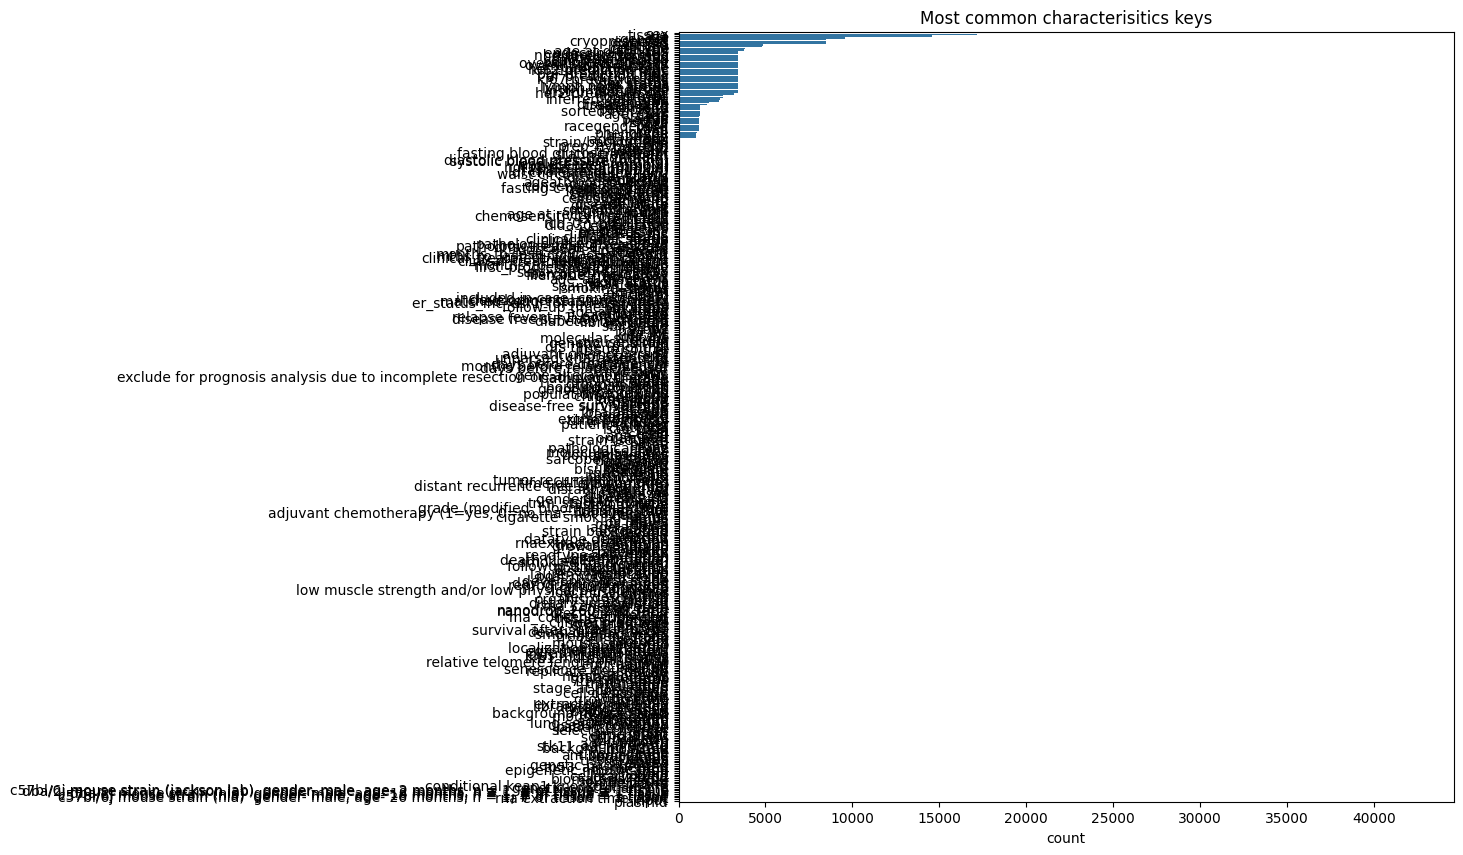

In [23]:
characteristics_keys = pd.Series([key for sample in samples for key in sample.characteristics])
frequent_characteristics_keys = remove_low_frequency_levels(characteristics_keys, 1000)
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_xlim(0, len(samples))
sns.countplot(frequent_characteristics_keys, ax=ax, order=characteristics_keys.value_counts().index)
ax.set_title("Most common characterisitics keys")

In [24]:
pd.Series(characteristics_keys).value_counts().head(10)

sex              18506
tissue           17161
age              14562
gender            9548
cryopreserved     8477
diabetes          8477
patched           8477
strain            4851
cell type         4817
cell line         3810
Name: count, dtype: int64

## Number of samples that have data tables

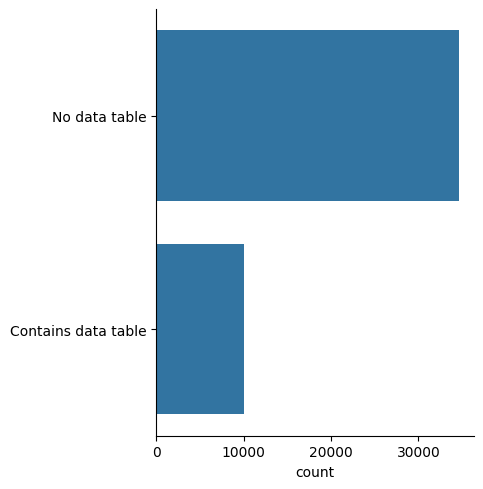

In [25]:
contains_data_table = ["Contains data table" if "data_row_count" in sample.metadata and sample.metadata["data_row_count"][0] != "0" else "No data table" for sample in samples]
sns.catplot(contains_data_table, kind="count")

It seems that relatively few samples have data tables. Therefore, most data is raw sequencing data. 

# What info can be found

In [26]:
def dataset_has_tissue_infomration(dataset: GEODataset):
    """
    Returns True if it is known which tissues were sampled for every
    sample in the dataset.
    All samples need to have the tissue characteric key for a dataset
    to be considered as having tissue information.
    If there are no samples in the datasets then the datasets does not have
    tissue information.

    :param datasets: GEODataset for which to check the presence of tissue information.
    :return: True if all samples have the 'tissue' characteristic key and there is
    at least one sample in the dataset, otherwise False.
    """
    if len(dataset.samples) == 0:
        return False
    return all("tissue" in sample.characteristics for sample in dataset.samples)

In [27]:
def dataset_has_sex_information(dataset: GEODataset):
    """
    Returns True if it the gender in the samples of a dataset is known.
    All samples need to have the sex or gender characteric keys 
    for a dataset to be considered as having sex information.
    If there are no samples in the datasets then the datasets does not have
    sex information.

    :param datasets: GEODataset for which to check the presence of sex information.
    :return: True if all samples have the 'sex' or 'gender' characteristic keys 
    and there is at least one sample in the dataset, otherwise False.
    """
    if len(dataset.samples) == 0:
        return False
    return all("sex" in sample.characteristics or "gender" in sample.characteristics for sample in dataset.samples)


In [28]:
def is_age_key(key: str):
    # We disqualify keys that contain the word "at" because then the age
    # becomes context-dependant.
    return ("age" in key.split(" ") or "age" in key.split("_")) and not "at" in key

for key in set(characteristics_keys):
    if is_age_key(key):
        print(key)

age
age_days
age (yr)
age group
donor_age
age (y)
age (yrs)
age (years)
age_years


In [29]:
def dataset_has_age_information(dataset: GEODataset):
    """
    Returns True if all samples in the datasets have a key
    that denotes age.
    """
    if len(dataset.samples) == 0:
        return False
    samples_contain_age_key = [any([is_age_key(
        key) for key in sample.characteristics.keys()]) for sample in dataset.samples]
    return all(samples_contain_age_key)

In [30]:
def is_dataset_about_humans(dataset: GEODataset):
    # A dataset has to be exclusively about humans
    return len(dataset.organisms) == 1 and dataset.organisms[0] == "Homo sapiens"

def is_dataset_about_mice(dataset: GEODataset):
    # A dataset has to be exclusively about mice
    return len(dataset.organisms) == 1 and dataset.organisms[0] == "Mus musculus"

In [31]:
human_datasets = list(filter(is_dataset_about_humans, datasets))
mice_datasets = list(filter(is_dataset_about_mice, datasets))

In [32]:
def add_percentages_to_countplot(ax, data, y_offset=1):
    # Calculate percentages and add text annotations
    total = len(data)
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height() / total)
        x = p.get_x() + p.get_width() / 2
        y = p.get_height() + y_offset
        ax.text(x, y, percentage, ha='center')

/tmp/ipykernel_969929/2279291711.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=datasets_have_sex_information, orient="v", palette=["red", "green"], order=["Absent", "Present"])


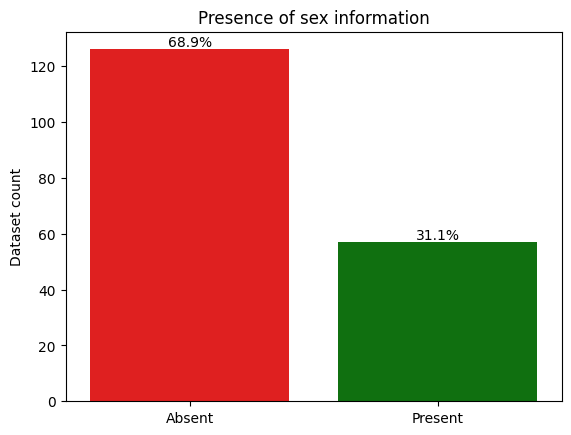

In [33]:
datasets_have_sex_information = pd.Series(["Present" if dataset_has_sex_information(dataset) else "Absent" for dataset in human_datasets])
ax = sns.countplot(x=datasets_have_sex_information, orient="v", palette=["red", "green"], order=["Absent", "Present"])
plt.title("Presence of sex information")
plt.xlabel("")
plt.ylabel("Dataset count")
add_percentages_to_countplot(ax, datasets_have_sex_information)

/tmp/ipykernel_969929/4055054208.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=datasets_have_age_information, orient="v", palette=["red", "green"], order=["Absent", "Present"])


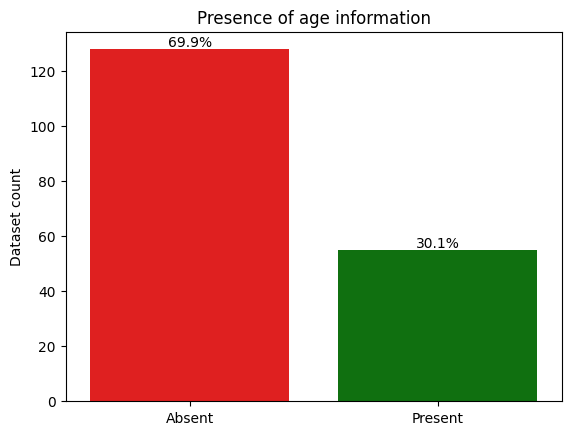

In [34]:
datasets_have_age_information = pd.Series(["Present" if dataset_has_age_information(dataset) else "Absent" for dataset in human_datasets])
ax = sns.countplot(x=datasets_have_age_information, orient="v", palette=["red", "green"], order=["Absent", "Present"])
plt.title("Presence of age information")
plt.xlabel("")
plt.ylabel("Dataset count")
add_percentages_to_countplot(ax, datasets_have_age_information)

In [35]:
def is_age_precise(dataset: GEODataset) -> str:
    sample_ages = get_sample_ages(dataset)
    if all(age is not None for age in sample_ages):
        return "Precise"
    if all(age is None for age in sample_ages):
        return "Imprecise"
    return "Mixed / has NAs"

/tmp/ipykernel_969929/1975238076.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=ages_quantitative, order=["Imprecise", "Mixed / has NAs", "Precise"], orient="v", palette=["red", "yellow", "green"])


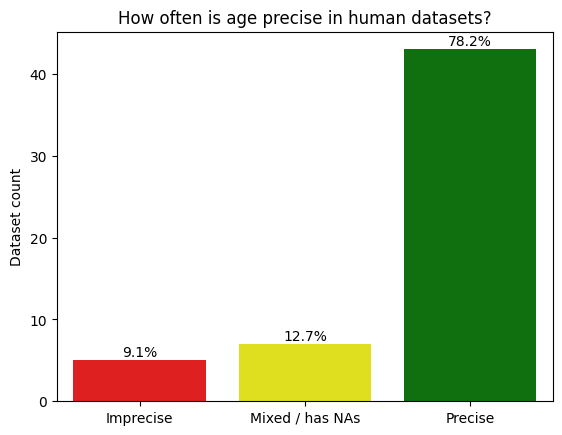

In [36]:
datasets_with_age = [dataset for dataset in human_datasets if dataset_has_age_information(dataset)]
ages_quantitative = pd.Series(list(map(is_age_precise, datasets_with_age)))
ax = sns.countplot(x=ages_quantitative, order=["Imprecise", "Mixed / has NAs", "Precise"], orient="v", palette=["red", "yellow", "green"])
plt.title("How often is age precise in human datasets?")
plt.xlabel("")
plt.ylabel("Dataset count")
add_percentages_to_countplot(ax, ages_quantitative, y_offset=0.5)

Text(0.5, 1.0, 'Age distribution in datasets where age is precise')

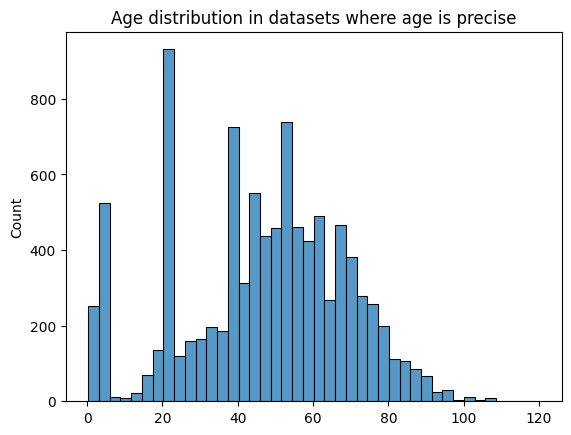

In [37]:
datasets_with_quantitative_age = [dataset for dataset in datasets_with_age if is_age_precise(dataset) == "Precise"]
quantitative_ages = list(itertools.chain.from_iterable(get_sample_ages(dataset) for dataset in datasets_with_quantitative_age))
quantitative_ages = [age if isinstance(age, float) else (age[0]+age[1])/2 for age in quantitative_ages] # Convert ranges to single numbers
sns.histplot(quantitative_ages)
plt.title("Age distribution in datasets where age is precise")

/tmp/ipykernel_969929/2501700311.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=presence_of_tissue_in_samples, orient="v", palette=["red", "green"], order=["Absent", "Present"])


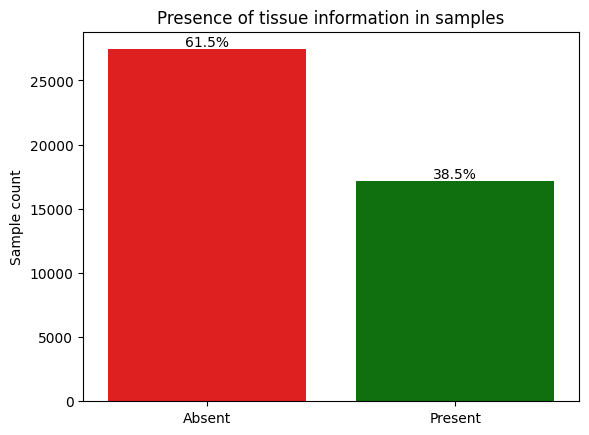

In [38]:
presence_of_tissue_in_samples = pd.Series(["Present" if "tissue" in sample.characteristics else "Absent" for sample in samples])
ax = sns.countplot(x=presence_of_tissue_in_samples, orient="v", palette=["red", "green"], order=["Absent", "Present"])
plt.title("Presence of tissue information in samples")
plt.xlabel("")
plt.ylabel("Sample count")
add_percentages_to_countplot(ax, presence_of_tissue_in_samples, y_offset=200)

/tmp/ipykernel_969929/3411560894.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=presence_of_cell_type_in_samples, orient="v", palette=["red", "green"], order=["Absent", "Present"])


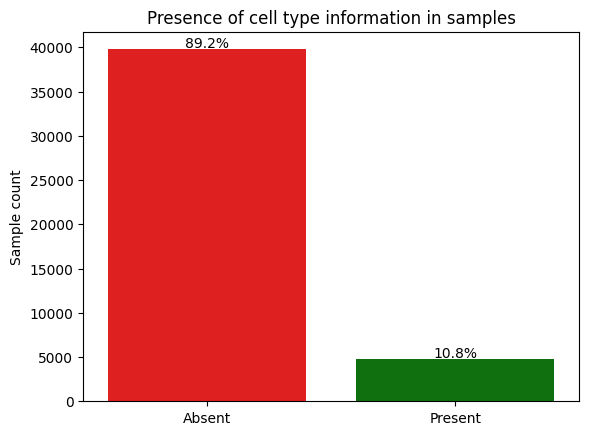

In [39]:
presence_of_cell_type_in_samples = pd.Series(["Present" if "cell type" in sample.characteristics else "Absent" for sample in samples])
ax = sns.countplot(x=presence_of_cell_type_in_samples, orient="v", palette=["red", "green"], order=["Absent", "Present"])
plt.title("Presence of cell type information in samples")
plt.xlabel("")
plt.ylabel("Sample count")
add_percentages_to_countplot(ax, presence_of_cell_type_in_samples, y_offset=200)

## Most common tissues

Text(0.5, 1.0, 'Number of samples per tissue')

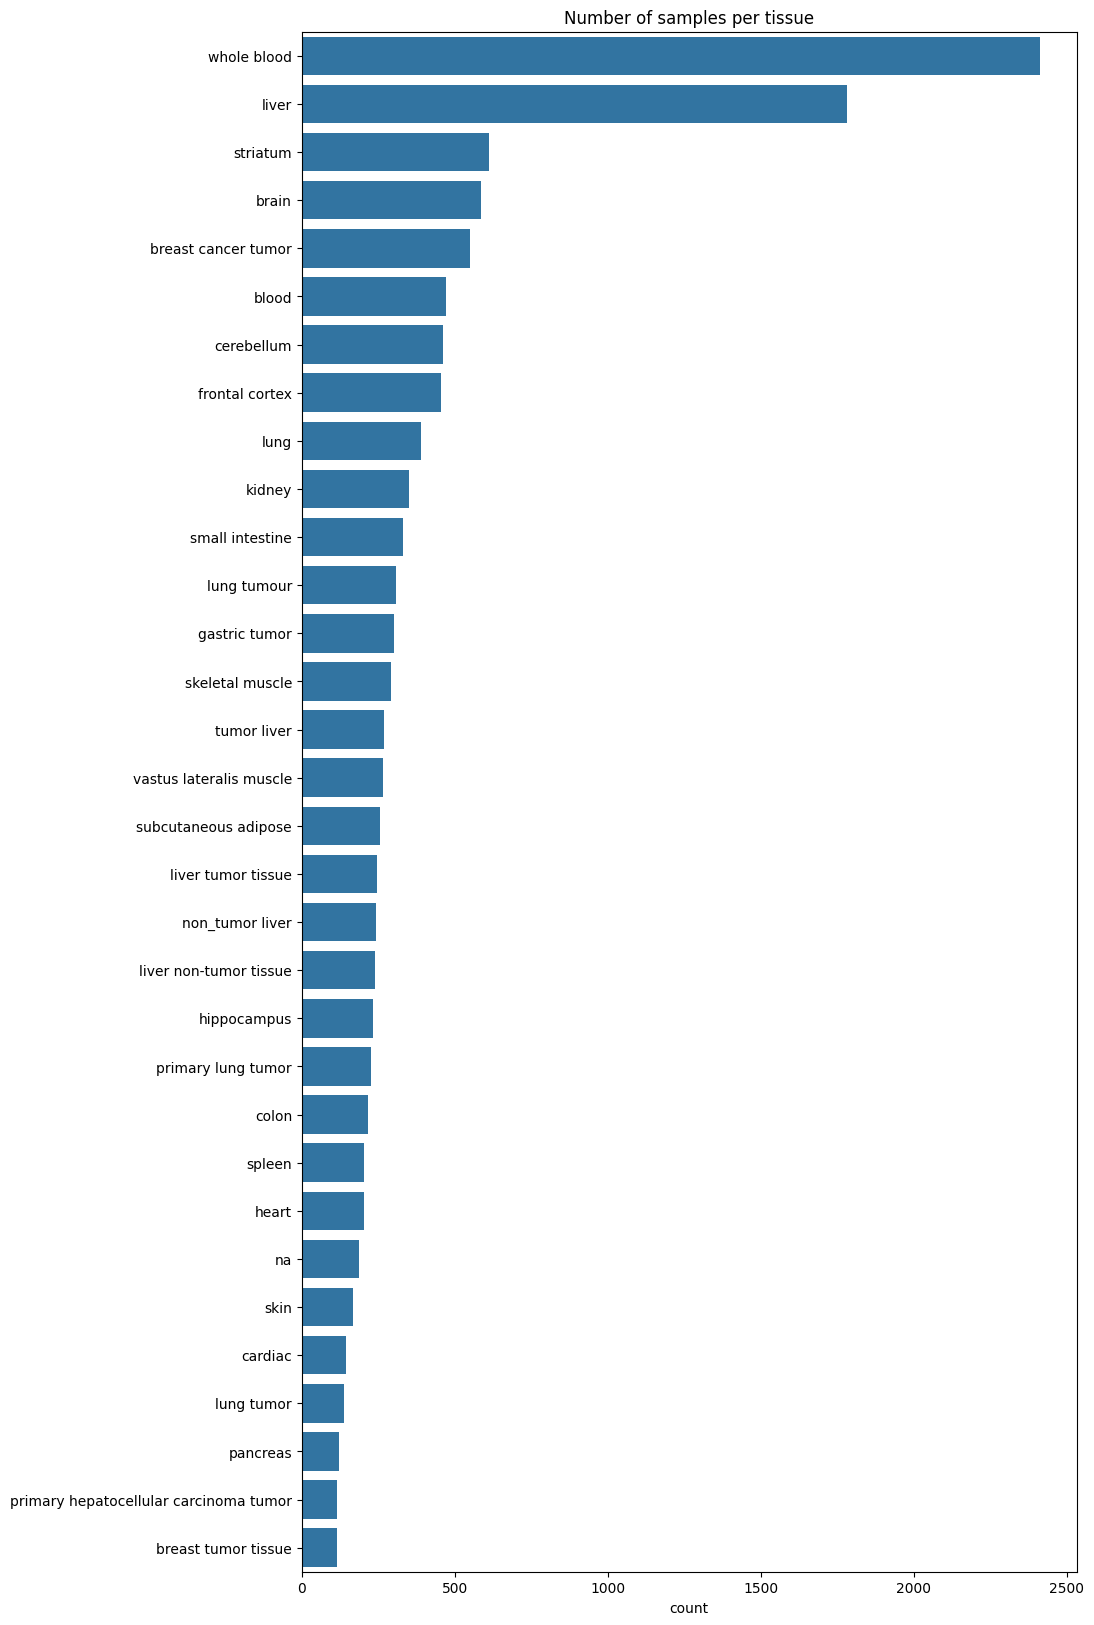

In [40]:
tissues = pd.Series([sample.characteristics["tissue"] for sample in samples if "tissue" in sample.characteristics])
tissues_processed = remove_low_frequency_levels(tissues, 100)
fig, ax = plt.subplots(figsize=(10, 20))
ax = sns.countplot(tissues_processed, ax=ax, order=tissues_processed.value_counts().index)
ax.set_title("Number of samples per tissue")

There are different names for the same tissue depending on how specific the author wanted to be. Let's try grouping the synonyms together.

The following groupings were obtained using LLama.3.3-70B with the following prompt:

Here is a list of tissue names as extracted from Gene Expression Omnibus sample records. There are different names for the same kind of tissue in the list. Group the synonymous tissue names and give the group a meaningful name. If there are no synonyms for a tissue type create a new group for each such tissue ("<tissue>": ["<tissue>"]). Do not create a category name like "Other". Make sure every item in the list is covered.

Output a JSON where the keys are the group names and the values are the synonyms in that group.

List of tissue names: \<python list of tissue names\>

In [41]:
synonym_groups = \
{
    "Fibroblasts": [
        "Dermal Fibroblast",
        "Fibroblast",
        "Fibroblasts",
        "Human Fibroblast",
        "Human embryonic lung fibroblasts",
        "Mouse embryonic fibroblast",
        "Mouse embryonic fibroblasts",
        "old fibroblasts",
        "Primary lung fibroblasts"
    ],
    "Neural Stem Cells": [
        "fetal primary NSC",
        "miNSC",
        "NSC",
        "old NSC",
        "old miNSC",
        "Primary neural stem cells"
    ],
    "Lung Cells": [
        "Lung cells",
        "mix cell types from lung"
    ],
    "Hepatocytes": [
        "hepatoma cell",
        "Hepatocyte",
        "hepatocellular carcinoma",
        "liver"
    ],
    "Mesenchymal Stromal Cells": [
        "Mesenchymal stromal cell",
        "Mesenchymal stromal cells",
        "human Mesenchymal stem cells",
        "mesenchymal stem cells"
    ],
    "Blood Cells": [
        "Bone marrow cells",
        "Bone marrow mononuclear cells",
        "Hematopoietic progenitors",
        "Hematopoietic stem cells",
        "leukocyte",
        "Peripheral mononuclear blood cell"
    ],
    "Stromal Cells": [
        "CD45-PECAM1+ thymic stroma cells",
        "CD45-PDGFRA+ thymic stroma cells",
        "CD45- thymic stroma cells",
        "Normal human primary prostate stromal cells",
        "stroma cells"
    ],
    "Epithelial Cells": [
        "Conjunctival epithelial cell",
        "corneal epithelial cell"
    ],
    "Muscle Cells": [
        "immortalized mouse myoblast",
        "muscle stem",
        "Pax7+ stem cells"
    ],
    "Immune Cells": [
        "Alveolar Macrophages",
        "B lymphoblastoid",
        "B lymphoblastoid, mouse embryonic stem cell",
        "primary T-cells",
        "T lymphocyte cells"
    ],
    "Yeast Cells": [
        "yeast cells"
    ],
    "Cell Culture": [
        "cell culture",
        "mixed cell culture",
        "mixture"
    ],
    "Brain Cells": [
        "astrocytes",
        "brain",
        "brain cells",
        "microglia",
        "neurons",
        "total brain cells"
    ],
    "Embryonic Stem Cells": [
        "mouse embryonic stem cell"
    ],
    "Podocytes": [
        "podocytes"
    ],
    "Leydig Cells": [
        "Leydig cells"
    ],
    "Endothelial Cells": [
        "Endothelial cells isolation(CD31 positive selection)"
    ],
    "Human Neuronal Cells": [
        "Human nueronal cells"
    ],
    "EPC": [
        "EPC"
    ],
    "NPC": [
        "NPC"
    ],
    "FAPs": [
        "FAPs"
    ],
    "MEF": [
        "MEF",
        "MEFs"
    ],
    "Human Embryonic Kidney": [
        "human embryonic kidney"
    ],
    "Dental Pulp Cell": [
        "Dental pulp cell"
    ],
    "Tissue Dissociated Cells": [
        "tissue dissociated cells"
    ],
    "Reprogramming Intermediate": [
        "Reprogramming intermediate"
    ],
    "Etoposide-induced Senescent Cells": [
        "Etoposide-induced senescent (ETIS) cells"
    ],
    "Carcinoma Cells": [
        "Carcinoma, derived from the metastatic site, bone of a prostate cancer patient",
        "Grade IV, adenocarcinoma, derived from the metastatic site, brain of a prostate cancer patient"
    ]
}

tissue_to_group_mapping = {tissue: group for group, tissue_list in synonym_groups.items() for tissue in tissue_list}

In [42]:
mapped_tissues = [tissue_to_group_mapping[tissue] if tissue in tissue_to_group_mapping else tissue for tissue in tissues]

Text(0.5, 1.0, 'Number of samples per tissue (synonyms grouped)')

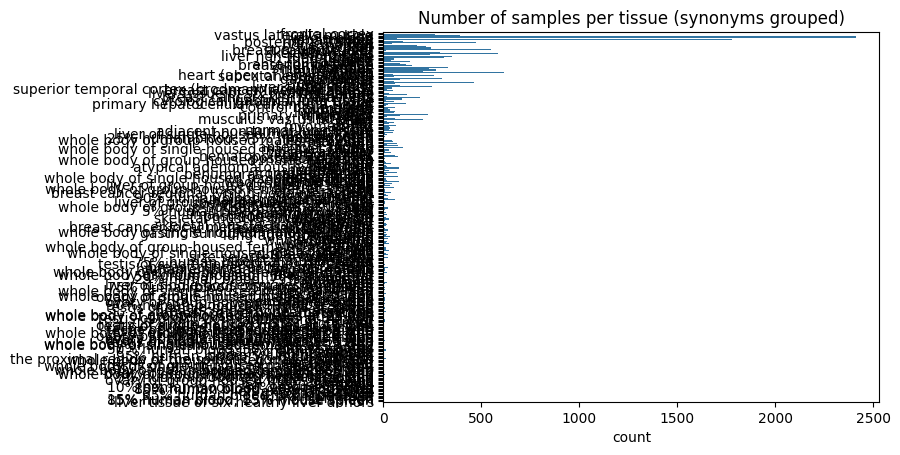

In [43]:
ax = sns.countplot(mapped_tissues)
ax.set_title("Number of samples per tissue (synonyms grouped)")

## Most common cell types

Text(0.5, 1.0, 'Number of samples per cell type')

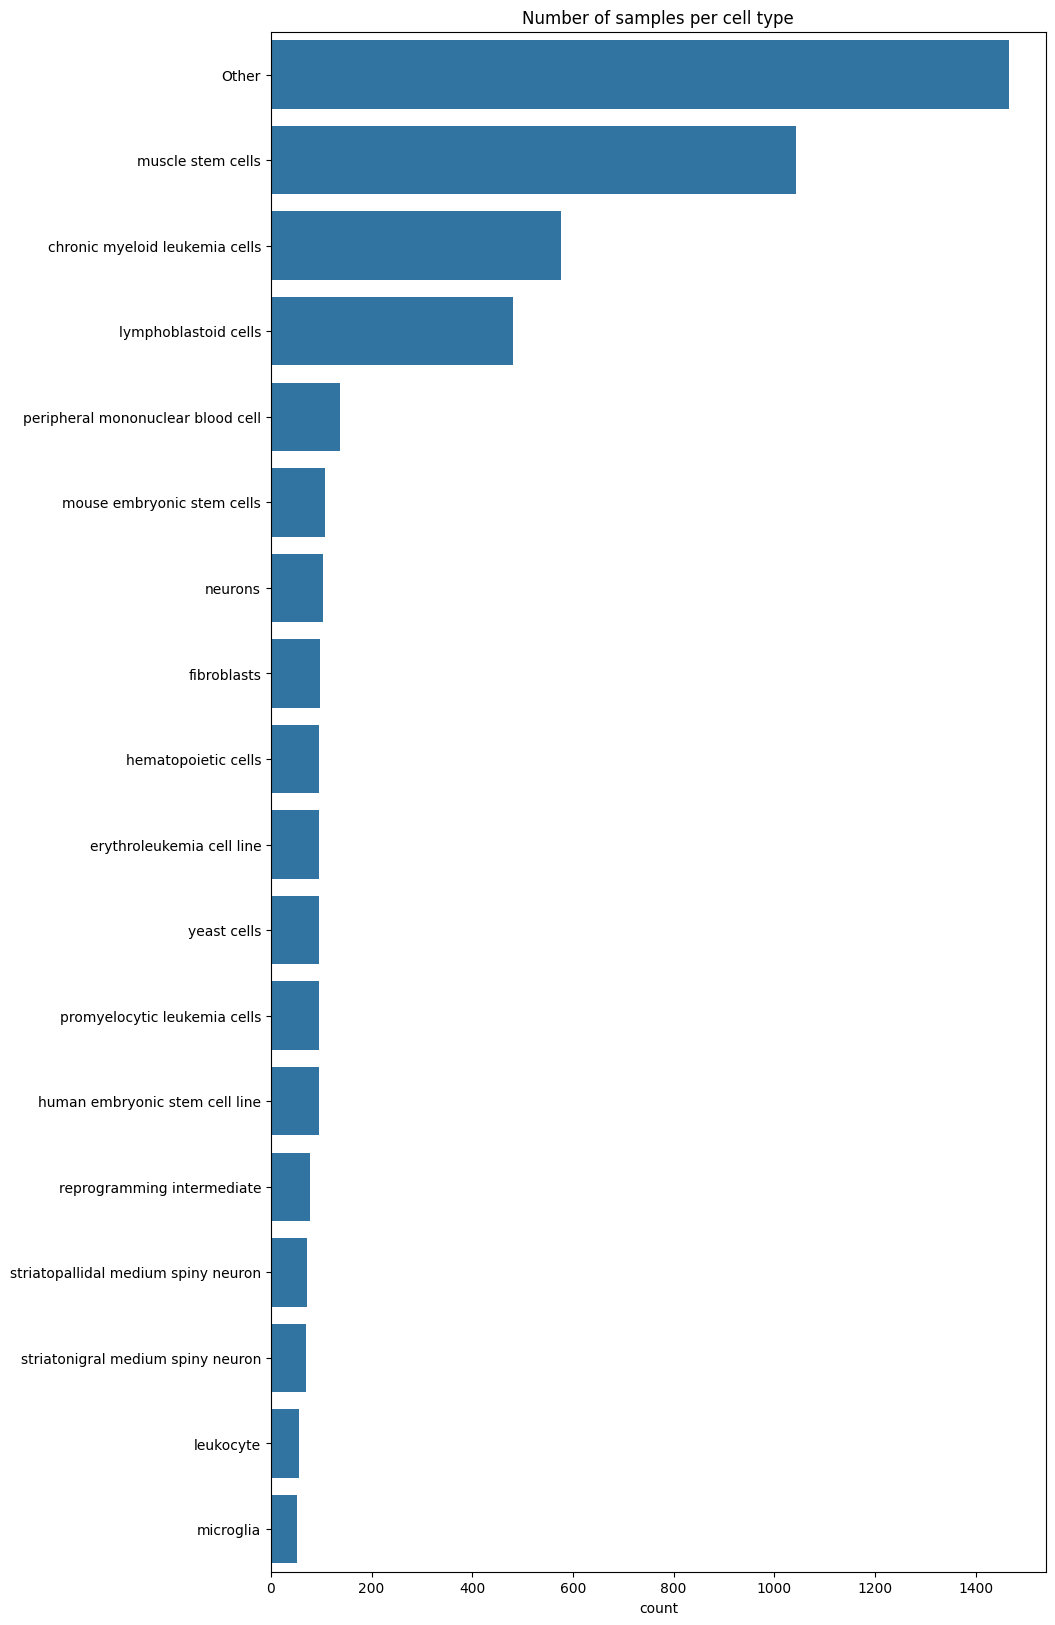

In [44]:
cell_types = pd.Series([sample.characteristics["cell type"] for sample in samples if "cell type" in sample.characteristics])
cell_types_processed = replace_low_frequency_levels_with_other(cell_types, 50)
fig, ax = plt.subplots(figsize=(10, 20))
ax = sns.countplot(cell_types_processed, ax=ax, order=cell_types_processed.value_counts().index)
ax.set_title("Number of samples per cell type")

There are synonyms here as well.

As a side note, let's see if most samples contain either the tissue type or cell type as both are indicative of the tissue being studied. 

In [45]:
contains_tissue_or_cell_type = [sample for sample in samples if "tissue" in sample.characteristics or "cell type" in sample.characteristics]
n_samples = len(samples)
n_contains = len(contains_tissue_or_cell_type)
print(f"{n_contains}/{n_samples} ({n_contains / n_samples * 100}%) contain tissue information")

20988/44591 (47.06779394945168%) contain tissue information


## Values of other characteristics fields

Time

In [46]:
time_values = [sample.characteristics["time"] for sample in samples if "time" in sample.characteristics]
time_values += [sample.characteristics["time point"] for sample in samples if "time point" in sample.characteristics]
for time in set(time_values):
    print(time)


isolation after 11 days of culture
2 hours
3 hours
3 months
24 months
control
day 5
day 0
basal
isolation after 21 days of culture
isolation after 7 days of culture
1 hour
7 hours
2hrs after the indicated surgery
72 h
isolation after 11 days after transfection
day 10
4hrs post exercise
isolation after 14 days of culture
24 hours
d0
12 months
6 hours
d0 (1st day of adulthood)
young adult (d1 of adulthood)


Age

In [47]:
age_keys = set([key for key in characteristics_keys if "age" in key.split(" ")])
age_values = []
for age_key in age_keys:
    age_values += [sample.characteristics[age_key] for sample in samples if age_key in sample.characteristics]
print("Keys:", age_keys)
for age_value in set(age_values):
    print(age_value)

Keys: {'age (yr)', 'age at diagnosis', 'age', 'age (years)', 'age category', 'age at death', 'age group', 'age at recruitment 1dp', 'age at surgery', 'age (y)', 'age (yrs)', 'age at diag'}
49.3
23.8
6 months
62.8
old_1
63.41
37.4
63.8
70.91
31.1
50.53251
24-month
49.4
61.53
67.29
72.4
93
11.9 weeks
71.92
72.3
79.1102
29 years old
58.23956
62.68
54.05613
82.6694
2yr3mos
20.1
62.9
8
69.92
64.19
90 years old
20-22 months
74.74
101
52.41341
55.96441
21-22months old
49.54963
8 months
38.1
41.7
68.9
59 years old
0.67
92
66.36824
6 months postnatal
48.3
43.10472
73.69
31.0
73.7
26.4
78.99
~1 year, adult
22.6
29.0486
--
90
106  years old
70.73
4 month
68.66
45.37166
12.0 weeks
32.8
70.82
63.21
13 weeks
33 years old
56.71
36
63.2
11
71.72895
older
67.6
61.86
29
68.32
14
2
86 wk
55.8
15mo
47.6
73.84805
61 years
96 weeks
18 month
56
3-4 months
56 years
94 years old
59.7
73.15811
57.31
65.05681
65.69
67.40588
69.2
55.4
18.2
30.2
13 wks
68.87
44.83231
27
49.53
58.1
3-4 months old
40.5
77.5
16.5 wk


## Parsing age fields

Age is usually represented here as a number or range followed by a unit, or just a number.
However there are excpetions to this rule, for example ">60 years old", and they have to be handled differently.
There are also non-numerical descriptions such as Young, Middle and Old which cannot be converted into numbers.

In [48]:
import re
INF_AGE = 999
MIN_AGE = 0


def normalize_to_years(value, unit):
    """Converts age to years based on the unit."""
    unit = unit.lower()
    if unit in ['year', 'years', 'yr', 'yrs', 'y']:
        return float(value)
    elif unit in ['month', 'months', 'mo', 'mos']:
        return float(value) / 12.0
    elif unit in ['week', 'weeks', 'wks', 'wk', 'w']:
        return float(value) / 52.0
    elif unit in ['day', 'days', 'd']:
        return float(value) / 365.0
    return None  # Should not happen if regex is correct


def extract_age(age_str: str):
    """
    Extratcts age in years or a range from a piece of text 
    stating the age or age group.
    If the age cannot be determined, the function returns null.

    :param age_str: Text from which to extract the age
    :returns: A single number containing the age or a pair if a range was detected.
    """
    age_str = str(age_str).lower().strip()  # Normalize text

    if is_number(age_str):
        return float(age_str)  # assume age is in years

    is_age_range, age_range = try_extract_age_range(age_str)
    if is_age_range:
        return age_range

    # Handle 110+
    is_age_plus, age_range = try_extract_age_plus(age_str)
    if is_age_plus:
        return age_range

    # Handle >60
    is_greater_than_age, age_range = try_extract_greater_than_age(age_str)
    if is_greater_than_age:
        return age_range
    
    # Handle <60
    is_less_than_age, age_range = try_extract_less_than_age(age_str)
    if is_less_than_age:
        return age_range

    is_age_plus_unit, age = try_extract_age_plus_unit(age_str)
    if is_age_plus_unit:
        return age

    
    return None


def try_extract_age_range(age_str: str):
    match = re.search(
        r'(\d+\.?\d*)\s*-\s*(\d+\.?\d*)\s*(year|yr|month|mo|week|wk|w|day|d)?s?\s*(old)?', age_str)
    if not match:
        return False, None
    val1 = float(match.group(1))
    val2 = float(match.group(2))
    unit = match.group(3)
    if unit:
        return True, (normalize_to_years(val1, unit), normalize_to_years(val2, unit))
    else:
        return True, (val1, val2)  # Assume years


def try_extract_age_plus_unit(age_str: str):
    match = re.search(
        r'(\d+\.?\d*)\s*-?\s*(year|yr|month|mo|week|wk|w|day|d)s?\s*-?\s*(old)?', age_str)
    if not match:
        return False, None
    if match:
        value = float(match.group(1))
        unit = match.group(2)
        return True, normalize_to_years(value, unit)


def try_extract_age_plus(age_str: str):
    """
    Tries to extract ages like 110+ out of the text.
    """
    match = re.search(r'(\d+)\+', age_str)
    if not match:
        return False, None
    if match:
        return True, (float(match.group(1)), INF_AGE)


def try_extract_greater_than_age(age_str: str):
    """
    Tries to extract ages like >20 out of the text.
    """
    match = re.search(r'\>(\d+)', age_str)
    if not match:
        return False, None
    if match:
        return True, (float(match.group(1)), INF_AGE)


def try_extract_less_than_age(age_str: str):
    """
    Tries to extract ages like <20 out of the text.
    """
    match = re.search(r'\<(\d+)', age_str)
    if not match:
        return False, None
    if match:
        return True, (MIN_AGE, float(match.group(1)))


def is_number(text):
    try:
        float(text)
        return True
    except:
        return False

In [49]:
for age in set(age_values):
    print(age, extract_age(age))

49.3 49.3
23.8 23.8
6 months 0.5
62.8 62.8
old_1 None
63.41 63.41
37.4 37.4
63.8 63.8
70.91 70.91
31.1 31.1
50.53251 50.53251
24-month 2.0
49.4 49.4
61.53 61.53
67.29 67.29
72.4 72.4
93 93.0
11.9 weeks 0.22884615384615387
71.92 71.92
72.3 72.3
79.1102 79.1102
29 years old 29.0
58.23956 58.23956
62.68 62.68
54.05613 54.05613
82.6694 82.6694
2yr3mos 2.0
20.1 20.1
62.9 62.9
8 8.0
69.92 69.92
64.19 64.19
90 years old 90.0
20-22 months (1.6666666666666667, 1.8333333333333333)
74.74 74.74
101 101.0
52.41341 52.41341
55.96441 55.96441
21-22months old (1.75, 1.8333333333333333)
49.54963 49.54963
8 months 0.6666666666666666
38.1 38.1
41.7 41.7
68.9 68.9
59 years old 59.0
0.67 0.67
92 92.0
66.36824 66.36824
6 months postnatal 0.5
48.3 48.3
43.10472 43.10472
73.69 73.69
31.0 31.0
73.7 73.7
26.4 26.4
78.99 78.99
~1 year, adult 1.0
22.6 22.6
29.0486 29.0486
-- None
90 90.0
106  years old 106.0
70.73 70.73
4 month 0.3333333333333333
68.66 68.66
45.37166 45.37166
12.0 weeks 0.23076923076923078
32.8 3

## Grouping tissues

In [50]:
import scispacy.linking_utils

def create_without_ner(knowledge_base="umls"):
    """
    Returns a scispacy NLP pipeline for entity linking with the UMLS database.
    """
    nlp = spacy.load("en_core_sci_md")

    # This line takes a while, because we have to download ~1GB of data
    # and load a large JSON file (the knowledge base). Be patient!
    # Thankfully it should be faster after the first time you use it, because
    # the downloads are cached.
    # NOTE: The resolve_abbreviations parameter is optional, and requires that
    # the AbbreviationDetector pipe has already been added to the pipeline. Adding
    # the AbbreviationDetector pipe and setting resolve_abbreviations to True means
    # that linking will only be performed on the long form of abbreviations.
    nlp.add_pipe("scispacy_linker", config={"resolve_abbreviations": True, "linker_name": knowledge_base})
    return nlp

def create_entity_linking_pipeline_with_ner(knowledge_base="umls"):
    """
    Returns a scispacy NLP pipeline for entity linking with the UMLS database
    that also performs named entity recognition.
    """
    nlp = spacy.load("en_ner_bionlp13cg_md")

    # This line takes a while, because we have to download ~1GB of data
    # and load a large JSON file (the knowledge base). Be patient!
    # Thankfully it should be faster after the first time you use it, because
    # the downloads are cached.
    # NOTE: The resolve_abbreviations parameter is optional, and requires that
    # the AbbreviationDetector pipe has already been added to the pipeline. Adding
    # the AbbreviationDetector pipe and setting resolve_abbreviations to True means
    # that linking will only be performed on the long form of abbreviations.
    nlp.add_pipe("scispacy_linker", config={"resolve_abbreviations": True, "linker_name": knowledge_base})
    return nlp


def link_entities(nlp, document: str) -> List[scispacy.linking_utils.Entity]:
    """
    Links entities in the document to the knowledge base of the scicpacy pipeline 
    and returns the canonical names and match scores.

    :param nlp: Scispacy NLP pipeline for entity linking and named entity
    recognition (see create_entity_linking_pipeline).
    :param document: The document in which to link entities to UMLS.
    :returns: A list of tuples (entity, canonical_name, score, label) where:
        1. entity is the name of the entity as it appears in the text.
        2. canonical_name is the canonical name of the entity in the knowledge base.
        3. score is the score of the knowledge base match. 
        4. NER label of the entity (e.g. ORGANISM, CELL, ...) 
        If an entity does not exist in the knowledge base it will be returned as (entity, entity, -1, None).
    """
    processed_doc = nlp(document)
    linker = nlp.get_pipe("scispacy_linker")
    knowledge_base = linker.kb
    all_links = []
    for ent in processed_doc.ents:
        if not ent._.kb_ents:
            all_links.append((ent, ent, -1, ent.label_))
            continue

        concept_id, score = ent._.kb_ents[0]
        umls_entity = knowledge_base.cui_to_entity[concept_id]
        canonical_name = umls_entity.canonical_name
        entity_link = (ent, canonical_name, score, ent.label_)
        all_links.append(entity_link)
            
    return all_links

def get_canonical_name(nlp, tissue: str):
    entity_links = link_entities(nlp, tissue)
    if not entity_links:
        return (tissue, tissue, -1)

    relevant_labels = ["CELL", "TISSUE", "ORGAN", "PATHOLOGICAL_FORMATION"]
    relevant_links = list(filter(lambda link: link[3] in relevant_labels, entity_links))
    if relevant_links:
        return max(relevant_links, key=lambda link: link[2])[:3] # Return link with the highest score
    return max(entity_links, key=lambda link: link[2])[:3]


In [51]:
nlp = create_entity_linking_pipeline_with_ner(knowledge_base="umls")

/home/Momir.Milutinovic/repos/pubmed-paper-exploration/.venv/lib/python3.12/site-packages/spacy/language.py:2195: FutureWarning: Possible set union at position 6328
  deserializers["tokenizer"] = lambda p: self.tokenizer.from_disk(  # type: ignore[union-attr]


{"asctime": "2025-06-16 10:45:50,116", "levelname": "INFO", "message": "Loading index from /home/Momir.Milutinovic/.scispacy/datasets/7e8e091ec80370b87b1652f461eae9d926e543a403a69c1f0968f71157322c25.6d801a1e14867953e36258b0e19a23723ae84b0abd2a723bdd3574c3e0c873b4.nmslib_index.bin"}
{"asctime": "2025-06-16 10:45:50,116", "levelname": "INFO", "message": "Loading regular index."}
{"asctime": "2025-06-16 10:45:58,097", "levelname": "INFO", "message": "Finished loading index"}
{"asctime": "2025-06-16 10:45:58,098", "levelname": "INFO", "message": "Set HNSW query-time parameters:"}
{"asctime": "2025-06-16 10:45:58,098", "levelname": "INFO", "message": "ef(Search)         =20"}
{"asctime": "2025-06-16 10:45:58,099", "levelname": "INFO", "message": "algoType           =2"}
{"asctime": "2025-06-16 10:45:58,100", "levelname": "INFO", "message": "Set HNSW query-time parameters:"}
{"asctime": "2025-06-16 10:45:58,101", "levelname": "INFO", "message": "ef(Search)         =200"}
{"asctime": "2025-06

/home/Momir.Milutinovic/repos/pubmed-paper-exploration/.venv/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator TfidfTransformer from version 1.1.2 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/Momir.Milutinovic/repos/pubmed-paper-exploration/.venv/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator TfidfVectorizer from version 1.1.2 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [52]:

unique_tissues = list(set(tissues))
 
entity_links_ner = [get_canonical_name(nlp, tissue) for tissue in unique_tissues]
for entity, canonical_name, score in entity_links_ner:
    print ("Entity:", entity)
    print ("Score:", score)
    print ("Cannonical name:", canonical_name)
    print("------")


Entity: whole organism
Score: -1
Cannonical name: whole organism
------
Entity: whole body of group-housed females at 13 dph
Score: -1
Cannonical name: whole body of group-housed females at 13 dph
------
Entity: tongue
Score: -1
Cannonical name: tongue
------
Entity: lung fibroblasts
Score: 0.8541043400764465
Cannonical name: Fibroblasts
------
Entity: testis
Score: 1.0
Cannonical name: Testis
------
Entity: breast cancer lung  
Score: 0.8106988072395325
Cannonical name: Malignant neoplasm of breast
------
Entity: lung
Score: 1.0
Cannonical name: Lung
------
Entity: peritoneum
Score: 1.0
Cannonical name: Peritoneum
------
Entity: liver tissue
Score: 1.0
Cannonical name: Liver parenchyma
------
Entity: tumor liver
Score: 1.0
Cannonical name: Liver neoplasms
------
Entity: kidney
Score: 1.0
Cannonical name: Kidney
------
Entity: cerebellum
Score: -1
Cannonical name: cerebellum
------
Entity: whole body of group-housed females at 35 dph
Score: -1
Cannonical name: whole body of group-house

### Scispacy vs LLM

In [53]:
tissue_standardization_df_dict = {
    "entity": unique_tissues,
    "scispacy_name": [link[1] for link in entity_links_ner],
    "llm_name": [tissue_to_group_mapping[tissue] if tissue in tissue_to_group_mapping else tissue for tissue in unique_tissues]
}
tissue_naming_df = pd.DataFrame(tissue_standardization_df_dict)
pd.set_option('display.max_rows', None)
tissue_naming_df

,entity,scispacy_name,llm_name
0,whole organism,whole organism,whole organism
1,whole body of group-housed females at 13 dph,whole body of group-housed females at 13 dph,whole body of group-housed females at 13 dph
2,tongue,tongue,tongue
3,ipscs from lung fibroblasts,Fibroblasts,ipscs from lung fibroblasts
4,testis of single-housed males at 11 wph,Testis,testis of single-housed males at 11 wph
5,breast cancer lung metastasis,Malignant neoplasm of breast,breast cancer lung metastasis
6,distal lung,Lung,distal lung
7,peritoneum,Peritoneum,peritoneum
8,liver tissue of six healthy liver donors,Liver parenchyma,liver tissue of six healthy liver donors
9,tumor liver,Liver neoplasms,tumor liver


### NER vs no NER

In [54]:
nlp_no_ner = create_without_ner()

{"asctime": "2025-06-16 10:46:53,801", "levelname": "INFO", "message": "Loading index from /home/Momir.Milutinovic/.scispacy/datasets/7e8e091ec80370b87b1652f461eae9d926e543a403a69c1f0968f71157322c25.6d801a1e14867953e36258b0e19a23723ae84b0abd2a723bdd3574c3e0c873b4.nmslib_index.bin"}
{"asctime": "2025-06-16 10:46:53,804", "levelname": "INFO", "message": "Loading regular index."}
{"asctime": "2025-06-16 10:47:00,671", "levelname": "INFO", "message": "Finished loading index"}
{"asctime": "2025-06-16 10:47:00,672", "levelname": "INFO", "message": "Set HNSW query-time parameters:"}
{"asctime": "2025-06-16 10:47:00,672", "levelname": "INFO", "message": "ef(Search)         =20"}
{"asctime": "2025-06-16 10:47:00,673", "levelname": "INFO", "message": "algoType           =2"}
{"asctime": "2025-06-16 10:47:00,673", "levelname": "INFO", "message": "Set HNSW query-time parameters:"}
{"asctime": "2025-06-16 10:47:00,674", "levelname": "INFO", "message": "ef(Search)         =200"}
{"asctime": "2025-06

/home/Momir.Milutinovic/repos/pubmed-paper-exploration/.venv/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator TfidfTransformer from version 1.1.2 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/Momir.Milutinovic/repos/pubmed-paper-exploration/.venv/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator TfidfVectorizer from version 1.1.2 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [55]:
entity_links_no_ner = [get_canonical_name(nlp_no_ner, tissue) for tissue in unique_tissues]
tissue_standardization_df_dict = {
    "entity": unique_tissues,
    "name with ner": [link[1] for link in entity_links_ner],
    "name without ner": [link[1] for link in entity_links_no_ner],
}
tissue_naming_df = pd.DataFrame(tissue_standardization_df_dict)
pd.set_option('display.max_rows', None)
tissue_naming_df

,entity,name with ner,name without ner
0,whole organism,whole organism,Organism
1,whole body of group-housed females at 13 dph,whole body of group-housed females at 13 dph,Females
2,tongue,tongue,Tongue
3,ipscs from lung fibroblasts,Fibroblasts,Lung
4,testis of single-housed males at 11 wph,Testis,Testis
5,breast cancer lung metastasis,Malignant neoplasm of breast,Malignant neoplasm of breast
6,distal lung,Lung,Distal (qualifier value)
7,peritoneum,Peritoneum,Peritoneum
8,liver tissue of six healthy liver donors,Liver parenchyma,Liver parenchyma
9,tumor liver,Liver neoplasms,Liver neoplasms


## Parsing cell types

In [56]:
cell_types = [sample.characteristics["cell type"] for sample in samples if "cell type" in sample.characteristics]
unique_cell_types = list(set(cell_types))

In [57]:
entity_links_cell_types = [get_canonical_name(nlp, cell_type) for cell_type in unique_cell_types]
cell_standardization_df_dict = {
    "Entity": unique_cell_types,
    "Name with NER": [link[1] for link in entity_links_cell_types],
}
cell_naming_df = pd.DataFrame(cell_standardization_df_dict)
pd.set_option('display.max_rows', None)
cell_naming_df

,Entity,Name with NER
0,aged skin hair follicle stem cells,Hair follicle structure
1,col2a1+ growth plate chondrocytes (tdtomato+),COL2A1 gene
2,primary astrocytes,Astrocytes
3,"interneuron, other",Interneurons
4,minsc,minsc
5,mixture,mixture
6,cd8 t-cells,CD8-Positive T-Lymphocytes
7,granulocyte monocyte progenitor (gmp),Granulocyte-Monocyte Progenitor Cell
8,astrocyte,Astrocytes
9,fibroblast,fibroblast


## Comparison between the Gilda-scispacy combined parser and the purely scispacy parser

In [58]:
from src.tissue_and_cell_type_standardization.get_standard_name import get_standard_name
from src.tissue_and_cell_type_standardization.is_mesh_term_in_anatomy_or_disease import build_mesh_lookup
mesh_lookup = build_mesh_lookup("desc2025.xml")
standardization_resources = StandardizationResources(mesh_lookup, nlp)

Building MeSH lookup from 'desc2025.xml'...
Lookup built successfully. Found 265680 unique terms.


### Tissue names

In [59]:
tissue_naming_df["gilda_name"] = tissue_naming_df["entity"].apply(get_standard_name, resources=standardization_resources)
tissue_naming_df[["entity", "name with ner", "gilda_name"]]

,entity,name with ner,gilda_name
0,whole organism,whole organism,whole organism
1,whole body of group-housed females at 13 dph,whole body of group-housed females at 13 dph,whole body of group-housed females at 13 dph
2,tongue,tongue,Tongue
3,ipscs from lung fibroblasts,Fibroblasts,Lung
4,testis of single-housed males at 11 wph,Testis,Testis
5,breast cancer lung metastasis,Malignant neoplasm of breast,Lung
6,distal lung,Lung,Lung
7,peritoneum,Peritoneum,Peritoneum
8,liver tissue of six healthy liver donors,Liver parenchyma,Liver
9,tumor liver,Liver neoplasms,Liver


In [60]:
cell_naming_df["gilda_name"] = cell_naming_df["Entity"].apply(get_standard_name, resources=standardization_resources)
cell_naming_df[["Entity", "Name with NER", "gilda_name"]]

,Entity,Name with NER,gilda_name
0,aged skin hair follicle stem cells,Hair follicle structure,Skin Neoplasms
1,col2a1+ growth plate chondrocytes (tdtomato+),COL2A1 gene,Chondrocytes
2,primary astrocytes,Astrocytes,Astrocytes
3,"interneuron, other",Interneurons,Interneurons
4,minsc,minsc,minsc
5,mixture,mixture,mixture
6,cd8 t-cells,CD8-Positive T-Lymphocytes,T-Lymphocytes
7,granulocyte monocyte progenitor (gmp),Granulocyte-Monocyte Progenitor Cell,Granulocytes
8,astrocyte,Astrocytes,Astrocytes
9,fibroblast,fibroblast,Fibroblasts


# Filtering datasets

## Retrieve by age range

In [61]:


def do_ranges_overlap(range1: Tuple[float, float], range2: Tuple[float, float]) -> bool:
    return range1[0] <= range2[1] and range2[0] <= range1[1]


def is_sample_in_age_range(sample: GEOSample, age_range: Tuple[float, float]) -> bool:
    """
    Returns true if a sample's age falls into the age range (inclusive).

    :param sample: GEO sample whose age to check.
    :param age_range: Age range (from, to).
    :return: True if age is in range, false if it is not. If the
    sample does not have an age key, the function returns false.
    """
    age = sample.characteristics.get("age") or sample.characteristics.get(
        "age (yr)") or sample.characteristics.get("age (years)")
    if not age:
        return False
    age = extract_age(age)

    if isinstance(age, float):
        return age_range[0] < age < age_range[1]
    elif isinstance(age, Tuple):
        return do_ranges_overlap(age, age_range)
    elif age is None:
        return False # Cannot compare qualitative ages
    else:
        raise ValueError(f"Extracted age is of unexpected type: {type(age)}")


def dataset_has_sample_in_age_range(dataset: GEODataset, age_range: Tuple[float, float]) -> float:
    """
    Returns true if a dataset contains a sample whose age
    falls into the age range (inclusive).

    :param dataset: Dataset in which to check if it contains a sample
    of the desired age.
    :param age_range: Age range (from, to).
    :return: True if the sample contains a sample whose age is in the
    given age range, otherwise False.
    """
    return any(
        [is_sample_in_age_range(sample, age_range)
         for sample in dataset.samples]
    )


def filter_by_age_range(datasets: List[GEODataset], age_range: Tuple[float, float]):
    """
    Retrieves datasets that have samples whose age falls into the age range (inclusive).

    :param datasets: List of GEO Datasests/Series to search by age.
    :age_range: Tuple containing the age range to search for (from, to).
    :return: List of GEO datasets which contain samples that fall into the
    desired age range.
    """
    return list(filter(lambda d: dataset_has_sample_in_age_range(d, age_range), datasets))

In [62]:
for d in filter_by_age_range(datasets, (18, 30)):
    print(d.id)


GSE233087
GSE182786
GSE235717
GSE152026
GSE165192
GSE121893
GSE30337
GSE167523
GSE133747
GSE87571
GSE116250
GSE109816
GSE120221
GSE53890
GSE202601
GSE226636
GSE125105
GSE212109
GSE76427
GSE113957
GSE275442
GSE164056
GSE147221
GSE17612
GSE84727
GSE178824
GSE80672
GSE21935
GSE201118
GSE30352
GSE242202
GSE136831
GSE80417
GSE130991


## Filter by presence of characteristic

In [63]:
def filter_by_has_characteristic(datasets: List[GEODataset], characteristic: List[str]):
    """
    Retrieves datasets that contain a sample that for which the given characteristic
    is specified.

    :param datasets: List of datasets to filter.
    :param characteristic: The characteristic the samples must have.
    :return: List of datasets which contain a sample that has the specified charcteristic.
    """
    return list(filter(
        lambda dataset: any(
            [characteristic in sample.characteristics for sample in dataset.samples]
        ),
        datasets
    ))

Let's see which datasets have sarcopenia status specified.

In [64]:
sarcopenia_datasets = filter_by_has_characteristic(datasets, "sarcopenia status")
for dataset in sarcopenia_datasets:
    print(dataset.id)
    print(dataset)

GSE111017
Study of sarcopenia in human muscle biopsies of elderly individuals
Expression profiling by high throughput sequencing
Homo sapiens
GSE111016
Study of sarcopenia in human muscle biopsies of elderly individuals, Singapore Sarcopenia Study
Expression profiling by high throughput sequencing
Purpose: The main goal of this study is to compare skeletal muscle transcriptome profilings derived from sarcopenic versus healthy subjects.
Homo sapiens
20 muscle biopsies from healthy subjects and 20 muscle biopsies from sarcopenic subjects.


Next, we will check out the composition of the samples.

In [65]:
def extract_characteristic_values(samples: List[GEOSample], characteristic: str):
    return[sample.characteristics[characteristic] for sample in samples if characteristic in sample.characteristics]


In [66]:
sarcopenia_samples = [sample for dataset in sarcopenia_datasets for sample in dataset.samples]
sarcopenia_samples = list(set(sarcopenia_samples)) # We need to remove duplicates because the first dataset is a superseries containing the second series
sarcopenia_statuses = extract_characteristic_values(sarcopenia_samples, "sarcopenia status")
sarcopenia_sample_sexes = extract_characteristic_values(sarcopenia_samples, "Sex")
sarcopenia_statuses = pd.Series(sarcopenia_statuses)
sarcopenia_sample_sexes = pd.Series(sarcopenia_sample_sexes)
print ("Sarcopenia status of the samples in the sarcopenia study")
print(sarcopenia_statuses.value_counts())
print ("Sexes of the samples in the sarcopenia study")
print(sarcopenia_sample_sexes.value_counts())

Sarcopenia status of the samples in the sarcopenia study
no     86
yes    33
Name: count, dtype: int64
Sexes of the samples in the sarcopenia study
Series([], Name: count, dtype: int64)


## Filter by publication date

In [67]:
def filter_by_publication_date(datasets: List, date_range: Tuple[datetime.datetime, datetime.datetime]):
    return filter(lambda d: date_range[0] <= d.publication_date <= date_range[1], datasets)

In [68]:
for dataset in filter_by_publication_date(datasets, (datetime.datetime(2020, 1, 1), datetime.datetime(2020, 12, 31))):
    print(dataset.id)
    print(dataset)

GSE150148
Emergence of CCL18- and IFI27-expressing macrophages in aging lungs, and potential roles for alveolar type 2 cell AGTR2 and macrophage BSG and CTSL expression in COVID-19
Expression profiling by high throughput sequencing
Aging lungs are associated with several lung diseases, including chronic obstructive pulmonary disease, idiopathic pulmonary fibrosis and pneumonia. This latter age-associated complication has been particularly prominent in the recent COVID-19 pandemic. We have analyzed carefully selected normal lung samples from human subjects at different ages simultaneously using hashtag-labeled samples and single cell RNA-sequencing technology. We identify prominent changes in macrophage populations in lungs from older individuals, including an emerging populations of macrophages expressing IFI27 and other interferon-regulated genes. We also see increased gene expression of CCL18 and other chemokines in FABP4+/alveolar and SPP1+/interstitial macrophages. All three macrop

# Parsed tissue and cell type breakdown

In [70]:
tissues_standardized_human = pd.Series([
    get_standard_name(sample.characteristics["tissue"], standardization_resources) 
    for dataset in human_datasets for sample in dataset.samples if "tissue" in sample.characteristics
])
tissues_standardized_mice = pd.Series([
    get_standard_name(sample.characteristics["tissue"], standardization_resources)
    for dataset in mice_datasets for sample in dataset.samples if "tissue" in sample.characteristics
])
cell_types_standardized_human = pd.Series([
    get_standard_name(sample.characteristics["cell type"], standardization_resources)
    for dataset in human_datasets for sample in dataset.samples if "cell type" in sample.characteristics
])
cell_types_standardized_mice = pd.Series([
    get_standard_name(sample.characteristics["cell type"], standardization_resources)
    for dataset in mice_datasets for sample in dataset.samples if "cell type" in sample.characteristics
])

In [71]:
sum(1 if "tissue" in sample.characteristics else 0 for dataset in (human_datasets + mice_datasets) for sample in dataset.samples)

15191

Total unique: 74


Text(0.5, 0, 'Sample count')

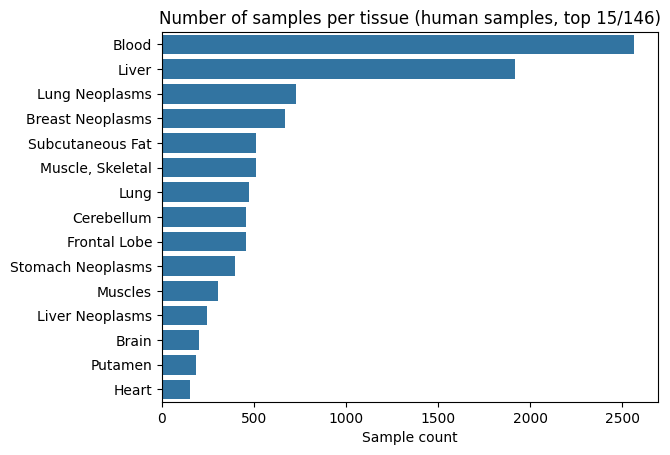

In [72]:
reduced_tissues_human = remove_low_frequency_levels(tissues_standardized_human, 145)
print(f"Total unique: {len(tissues_standardized_human.value_counts().index)}")
sns.countplot(reduced_tissues_human, order=reduced_tissues_human.value_counts().index)
plt.title("Number of samples per tissue (human samples, top 15/146)")
plt.xlabel("Sample count")

Total unique: 52


Text(0.5, 0, 'Sample count')

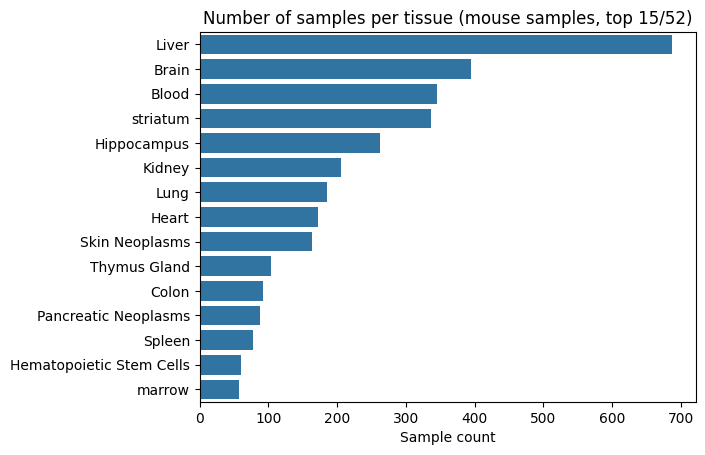

In [73]:
reduced_tissues_mice = remove_low_frequency_levels(tissues_standardized_mice, 57)
sns.countplot(reduced_tissues_mice, order=reduced_tissues_mice.value_counts().index)
print(f"Total unique: {len(tissues_standardized_mice.value_counts().index)}")
plt.title("Number of samples per tissue (mouse samples, top 15/52)")
plt.xlabel("Sample count")

Total unique: 45


Text(0.5, 0, 'Sample count')

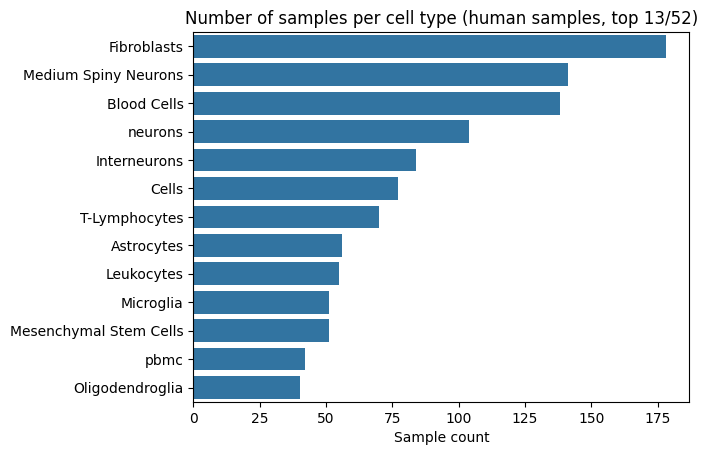

In [74]:
reduced_cell_types_human = remove_low_frequency_levels(cell_types_standardized_human, 30)
print(f"Total unique: {len(cell_types_standardized_human.value_counts().index)}")
sns.countplot(reduced_cell_types_human, order=reduced_cell_types_human.value_counts().index)
plt.title("Number of samples per cell type (human samples, top 13/52)")
plt.xlabel("Sample count")

Total unique: 45


Text(0.5, 0, 'Sample count')

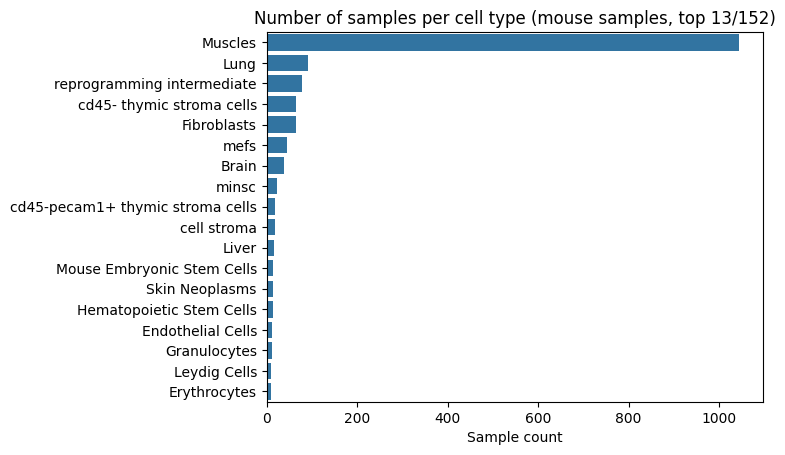

In [75]:
reduced_cell_types_mice = remove_low_frequency_levels(cell_types_standardized_mice, 10)
print(f"Total unique: {len(cell_types_standardized_mice.value_counts().index)}")
sns.countplot(reduced_cell_types_mice, order=reduced_cell_types_mice.value_counts().index)
plt.title("Number of samples per cell type (mouse samples, top 13/152)")
plt.xlabel("Sample count")

In [77]:
def get_standard_names_for_characteristic(dataset, characteristic: str) -> Set[str]:
    return {
        get_standard_name(sample.characteristics[characteristic], standardization_resources)
        for sample in dataset.samples if characteristic in sample.characteristics
    }

Text(0.5, 0, 'Dataset count')

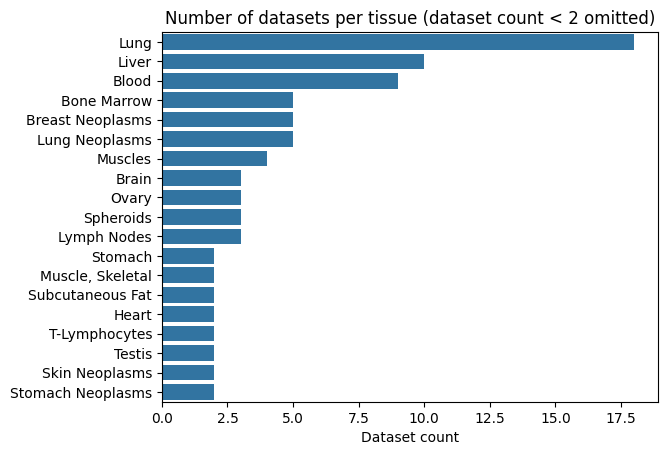

In [78]:
tissues_datasets_level_human = pd.Series(itertools.chain.from_iterable(get_standard_names_for_characteristic(dataset, "tissue") for dataset in human_datasets))
reduced_tissues_datasets_level_human = remove_low_frequency_levels(tissues_datasets_level_human, 2)
sns.countplot(reduced_tissues_datasets_level_human, order=reduced_tissues_datasets_level_human.value_counts().index)
plt.title("Number of datasets per tissue (dataset count < 2 omitted)")
plt.xlabel("Dataset count")

# Source name analysis

In [79]:
samples_that_do_not_contain_tissue_nor_cell_type = [
    sample for sample in samples if "tissue" not in sample.characteristics and "cell type" not in sample.characteristics
]
import random
for i in range(20):
    random_sample = random.choice(samples_that_do_not_contain_tissue_nor_cell_type)
    print(random_sample.accession)
    print(random_sample.metadata.get("source_name_ch1", "N/A"))

GSM3550395
['pancreatic islets']
GSM7029264
['HEK293T']
GSM3547075
['pancreatic islets']
GSM4599394
['Whole Blood']
GSM2172306
['Pancreatic islet']
GSM615192
['breast cancer, sample MDACC-M139']
GSM2529692
['Primary breast tumor']
GSM3547811
['pancreatic islets']
GSM2530843
['Primary breast tumor']
GSM2173818
['Pancreatic islet']
GSM2172824
['Pancreatic islet']
GSM3545848
['pancreatic islets']
GSM2528508
['Primary breast tumor']
GSM3546362
['pancreatic islets']
GSM2172602
['Pancreatic islet']
GSM3552350
['pancreatic islets']
GSM2530336
['Primary breast tumor']
GSM4599177
['Whole Blood']
GSM3547813
['pancreatic islets']
GSM3547028
['pancreatic islets']


In [ ]:
source_names = [sample.metadata["source_name_ch1"][0] for sample in samples_that_do_not_contain_tissue_nor_cell_type if "source_name_ch1" in sample.metadata]
standardized_sample_names = [get_standard_name(source_name, standardization_resources) for source_name in source_names]
sample_name_seems_to_have_been_parsed = [standardized_sample_names[i] for i in range(len(source_names)) if source_names[i] != standardized_sample_names[i]]

{"asctime": "2025-06-16 10:49:39,646", "levelname": "INFO", "message": "Running Gilda disambiguation for AT2"}
{"asctime": "2025-06-16 10:49:39,658", "levelname": "INFO", "message": "Running Gilda disambiguation for TRAM"}
{"asctime": "2025-06-16 10:49:39,716", "levelname": "INFO", "message": "Running Gilda disambiguation for CR"}
{"asctime": "2025-06-16 10:49:39,785", "levelname": "INFO", "message": "Running Gilda disambiguation for AT2"}
{"asctime": "2025-06-16 10:49:39,870", "levelname": "INFO", "message": "Running Gilda disambiguation for AT2"}
{"asctime": "2025-06-16 10:49:39,951", "levelname": "INFO", "message": "Running Gilda disambiguation for AT2"}
{"asctime": "2025-06-16 10:49:39,977", "levelname": "INFO", "message": "Running Gilda disambiguation for TRAM"}
{"asctime": "2025-06-16 10:49:39,981", "levelname": "INFO", "message": "Running Gilda disambiguation for AT2"}
{"asctime": "2025-06-16 10:49:40,054", "levelname": "INFO", "message": "Running Gilda disambiguation for TRAM"}

In [88]:
print("Parsed sample names:", len(sample_name_seems_to_have_been_parsed))
print("Total sample names:", len(source_names))

Parsed sample names: 22516
Total sample names: 23602


In [89]:
page = 213
for i in range(page * 20, (page+1)*20):
    print(f"{source_names[i]} | {standardized_sample_names[i]}")

pancreatic islets | Islets of Langerhans
Pancreatic islet | Islets of Langerhans
pancreatic islets | Islets of Langerhans
Whole Blood | Blood
case blood | Blood
pancreatic islets | Islets of Langerhans
pancreatic islets | Islets of Langerhans
Whole Blood | Blood
pancreatic islets | Islets of Langerhans
pancreatic islets | Islets of Langerhans
pancreatic islets | Islets of Langerhans
Whole Blood | Blood
pancreatic islets | Islets of Langerhans
Skin; Inguinal area | Skin Neoplasms
pancreatic islets | Islets of Langerhans
Whole blood | Blood
Whole Blood | Blood
MCF-7 | MCF-7 Cells
pancreatic islets | Islets of Langerhans
Liver | Liver
